In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

fair_GRU_test = False

In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

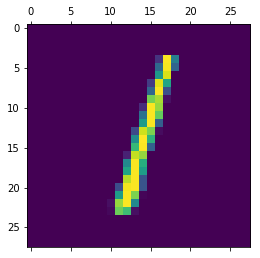

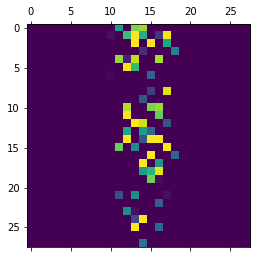

In [3]:
plt_data = np.reshape(test_data,[-1,28,28])

plt.matshow(plt_data[2])
plt.show()

def get_batch_shuffle(x,p):
    z = np.array([x[:,p[i],i] for i in range(len(p))]).transpose([1,2,0])
    return z

shuff = np.array([np.random.choice(range(28),28,replace=False) for k in range(28)])
out_data = get_batch_shuffle(plt_data,shuff)
plt.matshow(out_data[2])
plt.show()

In [4]:
batch_size = 16
data_size = len(test_data[0])
data_edge = int(np.sqrt(data_size))
learning_rate = .001
n_epochs = 4000
n_labels = 10

nrnn_hidden_layer = 32

rec_state_size = 128

In [5]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

In [31]:
ncontext = 5

shuff = [np.array([np.random.choice(range(28),28,replace=False) for k in range(28)]) for j in range(ncontext)]

tf.reset_default_graph()

rec = True

if rec:
    rec_contexts = tf.stop_gradient(tf.Variable(np.float32(np.random.randint(0,2,[ncontext,rec_state_size,rec_state_size])*2 - 1),trainable = False))
    inp_contexts = tf.stop_gradient(tf.Variable(np.float32(np.ones([ncontext,data_edge])),trainable = False))
else:
    rec_contexts = tf.stop_gradient(tf.Variable(np.float32(np.ones([ncontext,rec_state_size,rec_state_size])),trainable = False))
    inp_contexts = tf.stop_gradient(tf.Variable(np.float32(np.random.randint(0,2,[ncontext,1,data_edge])*2 - 1),trainable = False))
    
context_index = tf.placeholder(tf.int32)

inputs = tf.placeholder(tf.float32,shape = (batch_size, data_edge, data_edge))
series = tf.transpose(inputs,[0,2,1])

labels = tf.placeholder(tf.float32,shape = (batch_size,10))

init_state = tf.zeros(shape = [rec_state_size])

RNN_W_tot = tf.Variable(np.float32(np.random.randn(rec_state_size,rec_state_size)/np.sqrt(rec_state_size)),name = "W")

RNN_W = RNN_W_tot * rec_contexts[context_index]
INP_W = tf.Variable(np.float32(np.random.randn(rec_state_size,data_edge)/np.sqrt(data_edge)),name = "I_W")/inp_contexts[context_index]

print(RNN_W.shape)
print(INP_W.shape)


(128, 128)
(128, 28)


0.070709154


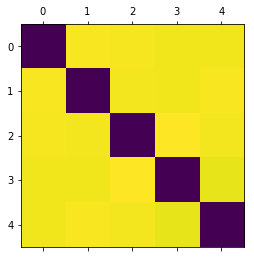

In [32]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

W = [sess.run(RNN_W,{context_index:c}) for c in range(ncontext)]
I = [sess.run(RNN_W,{context_index:c}) for c in range(ncontext)]
print(np.mean(np.abs(W[0] - W[1])))


wt = [[np.mean(np.abs(i - j)) for j in W] for i in W]

plt.matshow(wt)
plt.show()

sess.close()

This next cell is the powerhouse. The function I define takes a single time step batch of inputs, and the current state of the network, and returns an updated state using a single hidden layer of nonlinearity.

Note the `name` keyword and `reuse = tf.AUTO_REUSE`. The name identifies this layer unambiguously, and `tf.AUTO_REUSE` tells tensorflow to reuse the weights if this layer already exists, and create them if it doesn't. That way, every time we call the function `get_next_state`, it applies the same parameters to the inputs, and the gradients are tied across all time steps.

Next I have constructed a loop which recursively feeds the RNN state and a single "time" slice to `get_next_state`, and records the results in a list `state_out`. Afterwards we concatenate (`tf.concat`) them all together along the 1-th axis, generating a time series of state variables. 

Lastly, we reshape the time-dependent state and pass them all through a single dense layer to translate them into logits in the label dimention (`probs`).

In [33]:
def get_next_state(INP,STATE):
    inp = tf.tensordot(INP,INP_W,axes = [[-1],[-1]])
    rec = tf.tensordot(INP,INP_W,axes = [[-1],[-1]])
    
    net = tf.nn.relu(inp + rec)

    return net

state_out = [tf.tile(tf.expand_dims(init_state,0),(batch_size,1))]

for k in range(data_edge):
        state_out.append(get_next_state(series[:,k],state_out[-1]))
        
state_out = tf.stack(state_out,axis = 1)
print(state_out.shape)

flattened_state = tf.reshape(state_out,[-1,rec_state_size])
flattened_probs = tf.layers.dense(flattened_state,n_labels)
probs = tf.reshape(flattened_probs,[state_out.shape[0],state_out.shape[1],n_labels])

print(probs.shape)

(16, 29, 128)
(16, 29, 10)


Here I constrtuct the loss function. I take the mean cross-entropy loss between prediction and label in the final `test_time` time steps. There is some shuffling of dimentions that happens here which could probably be skipped with a clever application of keyowrd arguments in various tensorflow functions. 

In [34]:
test_time = 20

time_label = tf.tile(tf.expand_dims(labels,1),[1,probs.shape[1],1])
flattened_label = tf.reshape(time_label[:,-test_time:],[-1,n_labels])

flattened_probs = tf.reshape(probs[:,-test_time:],[-1,n_labels])
test_probs = tf.nn.softmax(probs,axis = -1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_probs))

adam = tf.train.AdamOptimizer()
train = adam.minimize(loss)

In [35]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

In [36]:
def TRAIN_LOOP(use_context):
    init = tf.global_variables_initializer()
    config = tf.ConfigProto(device_count = {'GPU': 0})
    sess = tf.Session(config=config)
    sess.run(init)
    
    results = []
    print_freq = 1000
    test_freq = 100

    normed_test = np.reshape((test_data - m)/s,[-1,28,28])

    normed_test = get_batch_shuffle(normed_test,shuff[0])
    test_label_1h = make_1hot(test_label)

    ntrain_per_cont = 2000
    n_epochs = ntrain_per_cont*ncontext

    print("epoch\trnn\trnn*\tcontext")

    for k in range(n_epochs):
        CONT = int(k/ntrain_per_cont)
        if use_context:
            trCONT = CONT
        else:
            trCONT = 0

        b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
        standard_batch_data = np.reshape(normed_data[b_index],[-1,28,28])
        batch_labels = make_1hot(train_label[b_index])

        batch_data = get_batch_shuffle(standard_batch_data,shuff[CONT])

        _,train_loss = sess.run([train,loss],{inputs:batch_data,labels:batch_labels,context_index:trCONT})

        if k%test_freq == 0:
            tres = []
            for j in range(len(normed_test)//16):
                tres.append(sess.run(loss,{inputs:normed_test[j*16:(j+1)*16],labels:test_label_1h[j*16:(j+1)*16],context_index:0}))

            tres = np.mean(tres)
            results.append([k,train_loss,tres])

        if k%print_freq == 0:
            print("{}\t{:.3f}\t{:.3f}\t{}".format(k,train_loss,tres,CONT))
            
    return np.array(results)

In [37]:
with_context = TRAIN_LOOP(True)
no_context = TRAIN_LOOP(False)

epoch	rnn	rnn*	context
0	3.681	3.531	0
1000	1.797	1.882	0
2000	2.691	1.791	1
3000	1.828	2.325	1
4000	2.736	2.516	2
5000	1.877	2.532	2
6000	2.493	2.678	3
7000	1.827	2.667	3
8000	2.689	2.750	4
9000	1.848	2.595	4
epoch	rnn	rnn*	context
0	3.948	3.794	0
1000	1.730	1.887	0
2000	2.738	1.792	1
3000	1.862	2.318	1
4000	2.869	2.486	2
5000	1.707	2.535	2
6000	2.612	2.647	3
7000	1.848	2.631	3
8000	2.669	2.736	4
9000	1.468	2.677	4


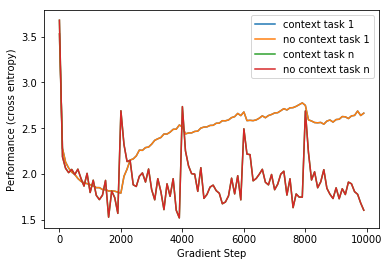

In [38]:
plt.plot(with_context[:,0],with_context[:,-1],label = "context task 1")
plt.plot(no_context[:,0],with_context[:,-1],label = "no context task 1")
plt.plot(with_context[:,0],with_context[:,1],label = "context task n")
plt.plot(no_context[:,0],with_context[:,1],label = "no context task n")
plt.xlabel("Gradient Step")
plt.ylabel("Performance (cross entropy)")
plt.legend()
plt.show()